<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/2D_Solvers_for_HeatEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) _INTRODUCTION TO 2D HEAT EQUATION_  
The 2D heat equation is a fundamental partial differential equation that describes how the temperature in a two-dimensional region changes over time due to heat diffusion. It's commonly used to model various physical phenomena involving heat transfer, such as the cooling of objects, thermal conduction in materials, and temperature distributions in engineering and environmental systems.

__Mathematical Formulation:__    
The 2D heat equation is typically expressed as:

```
dT_dt = alpha * (d2T_dx2 + d2T_dy2)
```
Where:

T(x, y, t) is the temperature distribution in the 2D domain at position (x, y) and time t.
alpha is the thermal diffusivity, a material property that represents how quickly heat diffuses through the medium.
dT_dt represents the rate of change of temperature with respect to time.
d2T_dx2 and d2T_dy2 represent the second derivatives of temperature with respect to the spatial coordinates x and y, respectively. These terms describe the spatial variations in temperature in the x and y directions.

__Physical Interpretation:__  
The 2D heat equation describes how the temperature at any point in the domain changes over time. It states that the rate of change of temperature at a given point is proportional to the Laplacian of the temperature distribution, which represents the spatial variation of temperature in all directions.

---
  
__Core Dependencies__
> numpy: 1.25.2  
plotly: 5.15.0  
scipy: 1.11.4  
tensorflow: 2.15.0  
keras: 2.15.0  
matplotlib: 3.7.1  

In [1]:
# @title #####__IMPORT__
locals().clear()
globals().clear()

import numpy as np
import plotly.graph_objects as go
from scipy.special import roots_legendre

import tensorflow as tf
from   tensorflow.keras import layers
from   tensorflow.keras.utils  import plot_model
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from   IPython.display import Image

#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________
#import os
#packages = [
#    'numpy',
#    'plotly',
#    'scipy',
#]
#
#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
#
#_______________________________________________________________________________
# THE FOLLOWING CODE WORKS PROPERLY WITH THESE PACKAGES VERSION:
#_______________________________________________________________________________
#numpy: 1.25.2
#plotly: 5.15.0
#scipy: 1.11.4
#_______________________________________________________________________________

# 1) _FINITE DIFFERENCE METHOD_

__Space Discretization:__    
The finite difference method discretizes the spatial domain into a grid and approximates spatial derivatives using finite differences. The central difference scheme is employed here for accuracy.  

```
dT_dx2 = (Tn[2:, 1:-1] - 2 * Tn[1:-1, 1:-1] + Tn[:-2, 1:-1]) / dx**2
dT_dy2 = (Tn[1:-1, 2:] - 2 * Tn[1:-1, 1:-1] + Tn[1:-1, :-2]) / dy**2

```  
__Time Discretization:__    
The temporal evolution of temperature is handled through explicit time integration using the forward Euler method.

```
T[1:-1, 1:-1] = Tn[1:-1, 1:-1] + dt * alpha * (dT_dx2 + dT_dy2)

```



In [2]:
# @title #####__Finite Difference Implementation__
# Finite difference scheme
def solve_heat_equation_FD(T0, nt, dt, dx, dy, alpha):
    T = T0.copy()
    for n in range(nt):
        Tn = T.copy()
        T[1:-1, 1:-1] = (Tn[1:-1, 1:-1] + alpha * dt * (
            (Tn[2:, 1:-1] - 2 * Tn[1:-1, 1:-1] + Tn[:-2, 1:-1]) / dx**2 +
            (Tn[1:-1, 2:] - 2 * Tn[1:-1, 1:-1] + Tn[1:-1, :-2]) / dy**2))

    T=T[1:-1, 1:-1]
    return T


# 2) _FINITE VOLUME METHOD_


__Space Discretization:__    
Finite volume methods divide the domain into control volumes and calculate fluxes at each face of these volumes. In this code, a structured grid is used, and each cell represents a control volume. Heat fluxes are computed at each control volume face based on the temperature gradients.

```
qx[i, j] = -alpha * (Tn[i, j] - Tn[i - 1, j]) / dx
qy[i, j] = -alpha * (Tn[i, j] - Tn[i, j - 1]) / dy

dTxdx = (qx[i, j] - qx[i + 1, j]) / dx
dTydy = (qy[i, j] - qy[i, j + 1]) / dy
```

__Time Discretization:__    
The temporal evolution of temperature is handled by iterating over each control volume and updating the temperature within each volume. The update is based on the fluxes calculated at the faces of each control volume using explicit Euler method.   


```
T[i, j] += dt * (dTxdx + dTydy)

```



In [3]:
# @title #####__Finite Volume Implementation__

# Finite volume scheme

def solve_heat_equation_FV(T0, nt, dt, dx, dy, alpha):
    nx, ny = T0.shape
    T = T0.copy()

    # Define the heat fluxes in the x and y directions
    qx = np.zeros((nx, ny))
    qy = np.zeros((nx, ny))

    for n in range(nt):
        Tn = T.copy()

        # Compute heat fluxes at each control volume face
        for i in range(1, nx):
            for j in range(1, ny):
                qx[i, j] = -alpha * (Tn[i, j] - Tn[i - 1, j]) / dx
                qy[i, j] = -alpha * (Tn[i, j] - Tn[i, j - 1]) / dy

        # Update temperatures within control volumes
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                dTxdx = (qx[i, j] - qx[i + 1, j]) / dx
                dTydy = (qy[i, j] - qy[i, j + 1]) / dy
                T[i, j] += dt * (dTxdx + dTydy)

    T=T[1:-1, 1:-1]

    return T


# 3) _PHYSICS INFORMED CONVOLUTIONAL NEURAL NETWORK_

In the following section, a convolutional physics-informed neural network will be implemented.   
In particular, the sections are divided into two main parts:  
 - __'data generation'__  
 a dataset with different initial conditions, integration step and respective solution will be constructed using the finite difference method.
 - __'model definition'__   
 the model will be defined, which will be able to accept the initial condition as a matrix and the integration step at which the solution is required. the substantial part of the implementation is the loss function where it is obtained from a classical MSE on the values, plus a component obtained from the error (MSE) on the Laplacian.   
 This forces the network to find a physically consistent solution.  



```
    # add a pad of zeros around the matrix to avoid shape reduction
    padded_y_pred = tf.pad(y_pred, [[0, 0], [1, 1], [1, 1]], 'CONSTANT')
    padded_y_true = tf.pad(y_true, [[0, 0], [1, 1], [1, 1]], 'CONSTANT')

    # Compute the Laplacian of the predicted temperature field using central difference method
    laplacian_pred_x = (padded_y_pred[0, :-2, :] - 2 * padded_y_pred[0, 1:-1, :] + padded_y_pred[0, 2:, :]) / (dx ** 2)
    laplacian_pred_y = (padded_y_pred[0, :, :-2] - 2 * padded_y_pred[0, :, 1:-1] + padded_y_pred[0, :, 2:]) / (dy ** 2)

    # Extract the inner part of the Laplacian that corresponds to the original y_pred shape
    laplacian_pred_x = laplacian_pred_x[:, 1:-1]
    laplacian_pred_y = laplacian_pred_y[1:-1, :]
    laplacian_pred   = laplacian_pred_x + laplacian_pred_y

    # Same for y_true
    laplacian_true_x = (padded_y_true[0, :-2, :] - 2 * padded_y_true[0, 1:-1, :] + padded_y_true[0, 2:, :]) / (dx ** 2)
    laplacian_true_y = (padded_y_true[0, :, :-2] - 2 * padded_y_true[0, :, 1:-1] + padded_y_true[0, :, 2:]) / (dy ** 2)

    laplacian_true_x = laplacian_true_x[:, 1:-1]
    laplacian_true_y = laplacian_true_y[1:-1, :]
    laplacian_true   = laplacian_true_x + laplacian_true_y

    # Computing Laplacian MSE
    laplacian_loss = K.mean(K.square(laplacian_true - laplacian_pred))
```



 The expected results are then a network capable of finding the results obtained by the finite difference method.   
 Note that the diffusivity coefficient is not provided to the network as it is extracted from the data.


In [4]:
# @title #####__Data Generation__

#-------------------------------------------------------------------------------
# DATA GENARATION FUNCTION & UTILITIES

Lx = Ly = 1.0  # Domain size
nx = ny = 5    # Number of elements in each dimension
dx = Lx / nx   # Element size in x-direction
dy = Ly / ny   # Element size in y-direction
dt = 0.001     # Time step size
alpha = 0.01   # Thermal diffusivity
#num_steps = 500  # Number of time steps

def plot_loss(history):
    plt.figure(figsize=(14, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_data(iteration = 8000, IC = None, total_steps = None, debug_plot=False):

    x = np.zeros((iteration, 5, 5))
    y = np.zeros((iteration, 5, 5))
    steps = np.zeros((iteration))

    for idx in range(iteration):

        if total_steps is None:
           num_steps = np.random.random_integers(low=100, high=2000)
        else:
           num_steps = total_steps

        T0 = np.zeros((nx +2, ny +2))

        h = (np.random.randint(6, size=(25)) / 5) * 100  #6 is excluded, max value is 5
        if idx % 20 == 0:
            T0 =    np.array([[0.,    0.,    0.,    0.,    0.,    0.,  0.],
                              [0.,  h[0],  h[1],  h[2],  h[3],  h[4],  0.],
                              [0.,  h[5],  h[6],  h[7],  h[8],  h[9],  0.],
                              [0., h[10], h[11], h[12], h[13], h[14],  0.],
                              [0., h[15], h[16], h[17], h[18], h[19],  0.],
                              [0., h[20], h[21], h[22], h[23], h[24],  0.],
                              [0.,    0.,    0.,    0.,    0.,    0.,  0.]
                             ])
        else:
            T0[int(np.random.uniform() + np.random.uniform() / dx +1):int(1 / dx +1),
               int(np.random.uniform() + np.random.uniform() / dy +1):int(1 / dy +1)] = 100


        if IC is None:
           IC_internal = T0
        else:
           IC_internal = IC

        T = IC_internal
        T = T.copy()
        for n in range(num_steps):
            Tn = T.copy()
            T[1:-1, 1:-1] = (Tn[1:-1, 1:-1] + alpha * dt * (
            (Tn[2:, 1:-1] - 2 * Tn[1:-1, 1:-1] + Tn[:-2, 1:-1]) / dx**2 +
            (Tn[1:-1, 2:] - 2 * Tn[1:-1, 1:-1] + Tn[1:-1, :-2]) / dy**2))

        x[idx] = IC_internal[1:-1, 1:-1] /100
        y[idx] = T[1:-1, 1:-1] /100
        steps[idx] = num_steps /2000

        if debug_plot == True:
          plt.figure(figsize=(5,5))
          plt.imshow(x[idx], cmap='viridis')
          plt.colorbar()
          plt.title(f'X {idx} Init Condition')
          plt.show()

          plt.figure(figsize=(5,5))
          plt.imshow(y[idx], cmap='viridis')
          plt.colorbar()
          plt.title(f'Y {idx} Sim Result - steps: {steps[idx] * 2000}')
          plt.show()

    return x, y, steps

x_data_train = []
y_data_train = []
t_train      = []

x_data_valid = []
y_data_valid = []
t_valid      = []

x_data_train, y_data_train, t_train = generate_data(total_steps=None)
x_data_valid, y_data_valid, t_valid = generate_data(iteration=300, total_steps=None)


Epoch 1/450
125/125 - 8s - loss: 13.3979 - mae: 0.2125 - val_loss: 19.4880 - val_mae: 0.1720 - 8s/epoch - 65ms/step
Epoch 2/450
125/125 - 7s - loss: 8.6415 - mae: 0.1617 - val_loss: 16.6842 - val_mae: 0.1409 - 7s/epoch - 57ms/step
Epoch 3/450
125/125 - 6s - loss: 7.7750 - mae: 0.1372 - val_loss: 14.4230 - val_mae: 0.1266 - 6s/epoch - 48ms/step
Epoch 4/450
125/125 - 7s - loss: 9.1961 - mae: 0.1228 - val_loss: 12.9538 - val_mae: 0.1347 - 7s/epoch - 56ms/step
Epoch 5/450
125/125 - 6s - loss: 5.2863 - mae: 0.1139 - val_loss: 14.4098 - val_mae: 0.1094 - 6s/epoch - 48ms/step
Epoch 6/450
125/125 - 7s - loss: 5.7755 - mae: 0.1008 - val_loss: 10.3572 - val_mae: 0.0945 - 7s/epoch - 57ms/step
Epoch 7/450
125/125 - 6s - loss: 4.0090 - mae: 0.0948 - val_loss: 11.3034 - val_mae: 0.1041 - 6s/epoch - 48ms/step
Epoch 8/450
125/125 - 7s - loss: 4.6196 - mae: 0.0872 - val_loss: 10.2735 - val_mae: 0.0830 - 7s/epoch - 57ms/step
Epoch 9/450
125/125 - 6s - loss: 3.6175 - mae: 0.0759 - val_loss: 11.4651 - val

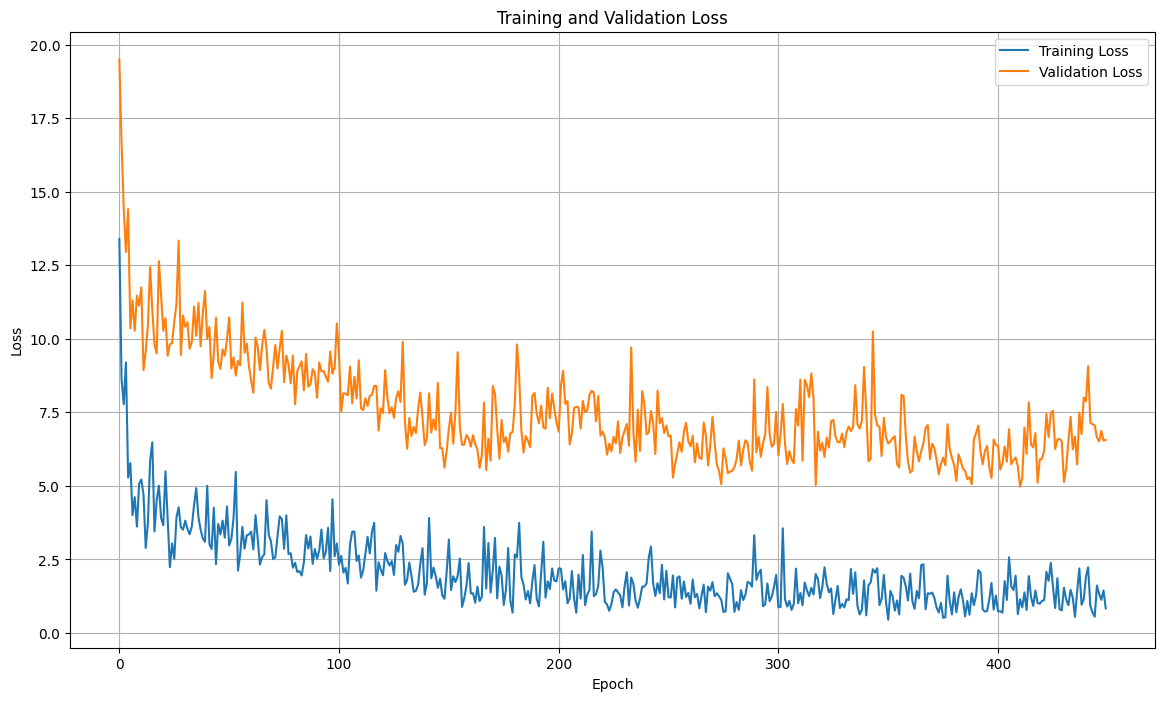

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


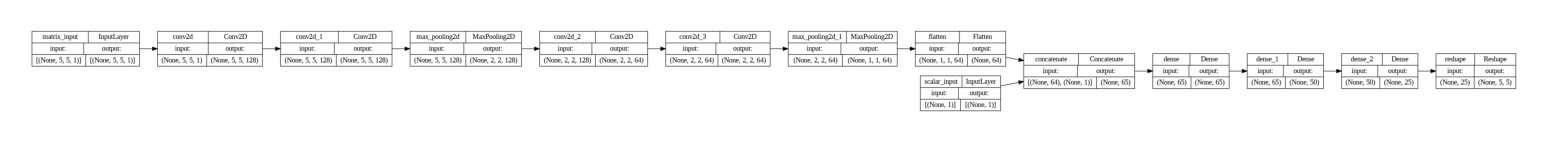

1/1 [==============================] - 0s 27ms/step - loss: 32.2538 - mae: 0.1380
Loss on Validation: [32.253787994384766, 0.13797850906848907]
1/1 [==============================] - 0s 146ms/step
[[[0.22997296 0.14629096 0.20392923 0.56981725 0.38931763]
  [0.4440483  0.13948669 0.23420571 0.22795336 0.11988893]
  [0.60948616 0.7962634  0.6417911  0.5994482  0.28680155]
  [0.6480895  0.7176732  0.47641164 0.4852801  0.46479177]
  [0.62836516 0.67991626 0.5038968  0.5453156  0.41255724]]]
[[[0.7043897  0.2316875  0.23339911 0.73751057 0.33828873]
  [0.53429556 0.16396394 0.16317112 0.52713664 0.13173125]
  [0.72400659 0.83837638 0.8298164  0.5690331  0.44586514]
  [0.82731274 0.53675425 0.53887934 0.15850333 0.10164001]
  [0.78114932 0.654499   0.2915955  0.45777212 0.43250779]]]
[[[-0.47441674 -0.08539654 -0.02946988 -0.16769333  0.0510289 ]
  [-0.09024728 -0.02447725  0.07103458 -0.29918328 -0.01184232]
  [-0.11452042 -0.04211298 -0.18802529  0.03041511 -0.1590636 ]
  [-0.17922322  0

In [5]:
# @title #####__Model Definition - Training & Testing__

#-------------------------------------------------------------------------------
# MODEL DEFINITION

matrix_input_shape = (5, 5, 1)
scalar_input_shape = (1)

matrix_input = layers.Input(shape=matrix_input_shape, name='matrix_input') #IC
scalar_input = layers.Input(shape=scalar_input_shape, name='scalar_input') #integration_steps (normalized over 2000)

conv_layer1   = layers.Conv2D(128,  (3, 3), activation='relu', padding='same')(matrix_input)
conv_layer2   = layers.Conv2D(128,  (3, 3), activation='relu', padding='same')(conv_layer1)
pool_layer1   = layers.MaxPooling2D((2, 2))(conv_layer2)
conv_layer3   = layers.Conv2D(64,   (1, 1), activation='relu', padding='same')(pool_layer1)
conv_layer4   = layers.Conv2D(64,   (3, 3), activation='relu', padding='same')(conv_layer3)
pool_layer2   = layers.MaxPooling2D((2, 2))(conv_layer4)

flatten_layer  = layers.Flatten()(pool_layer2)
combined_input = layers.concatenate([flatten_layer, scalar_input])

dense_layer1  = layers.Dense(65, activation='tanh')(combined_input)
dense_layer2  = layers.Dense(50, activation='tanh')(dense_layer1)

output_dense = layers.Dense(25,  activation='elu')(dense_layer2)
final_output = layers.Reshape((5, 5))(output_dense)

#-------------------------------------------------------------------------------
# CUSTOM LOSS DEFINITION

def custom_loss(y_true, y_pred):
    # Define constants for the heat equation
    dx = 1/5
    dy = 1/5
    #print(y_true.shape)
    #print(y_pred.shape)

    # add a pad of zeros around the matrix to avoid shape reduction
    padded_y_pred = tf.pad(y_pred, [[0, 0], [1, 1], [1, 1]], 'CONSTANT')
    padded_y_true = tf.pad(y_true, [[0, 0], [1, 1], [1, 1]], 'CONSTANT')

    # Example:
    # y_pred = tf.constant([[[1, 2, 3, 4, 5],
    #                   [6, 7, 8, 9, 10],
    #                   [11, 12, 13, 14, 15],
    #                   [16, 17, 18, 19, 20],
    #                   [21, 22, 23, 24, 25]]])
    # tf.Tensor(
    # [[[ 0  0  0  0  0  0  0]
    # [ 0  1  2  3  4  5  0]
    # [ 0  6  7  8  9 10  0]
    # [ 0 11 12 13 14 15  0]
    # [ 0 16 17 18 19 20  0]
    # [ 0 21 22 23 24 25  0]
    # [ 0  0  0  0  0  0  0]]], shape=(1, 7, 7), dtype=int32)

    # Compute the Laplacian of the predicted temperature field using central difference method
    laplacian_pred_x = (padded_y_pred[0, :-2, :] - 2 * padded_y_pred[0, 1:-1, :] + padded_y_pred[0, 2:, :]) / (dx ** 2)
    laplacian_pred_y = (padded_y_pred[0, :, :-2] - 2 * padded_y_pred[0, :, 1:-1] + padded_y_pred[0, :, 2:]) / (dy ** 2)

    # Extract the inner part of the Laplacian that corresponds to the original y_pred shape
    laplacian_pred_x = laplacian_pred_x[:, 1:-1]
    laplacian_pred_y = laplacian_pred_y[1:-1, :]
    laplacian_pred   = laplacian_pred_x + laplacian_pred_y


    laplacian_true_x = (padded_y_true[0, :-2, :] - 2 * padded_y_true[0, 1:-1, :] + padded_y_true[0, 2:, :]) / (dx ** 2)
    laplacian_true_y = (padded_y_true[0, :, :-2] - 2 * padded_y_true[0, :, 1:-1] + padded_y_true[0, :, 2:]) / (dy ** 2)

    laplacian_true_x = laplacian_true_x[:, 1:-1]
    laplacian_true_y = laplacian_true_y[1:-1, :]
    laplacian_true   = laplacian_true_x + laplacian_true_y

    laplacian_loss = K.mean(K.square(laplacian_true - laplacian_pred))
    mse_loss = K.mean(K.square(y_true - y_pred))

    total_loss = 0.9 * mse_loss + 0.1 * laplacian_loss

    return total_loss

#-------------------------------------------------------------------------------
# MODEL TRAINING - TESTING

heat_solver = tf.keras.Model(inputs=[matrix_input, scalar_input], outputs=final_output, name="heat_solver")
heat_solver.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])

history = heat_solver.fit([x_data_train, t_train], y_data_train, validation_data=([x_data_valid, t_valid], y_data_valid), epochs=450, batch_size=64, verbose=2)
plot_loss(history)

heat_solver.save("HE_model.h5")
plot_model(heat_solver, to_file='HE_model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')
plt.figure(dpi=300)
img = plt.imread('HE_model_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()

x_data_test, y_data_test, t_test= generate_data(iteration = 1)
loss = heat_solver.evaluate([x_data_test, t_test], y_data_test)
print("Loss on Validation:", loss)

predicted_T = heat_solver.predict([x_data_test, t_test])
print(predicted_T)
print(y_data_test)
print(predicted_T - y_data_test)

#-------------------------------------------------------------------------------


V0 = 0

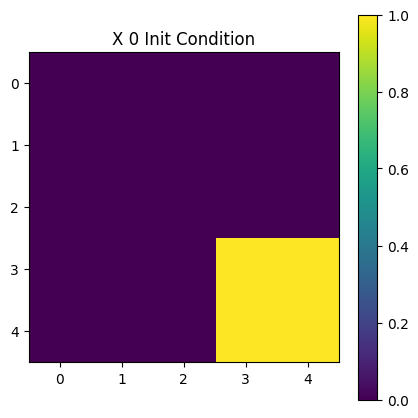

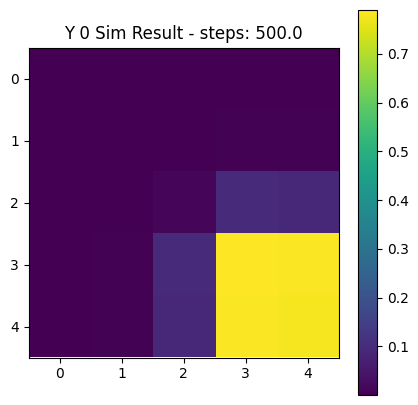

1/1 [==============================] - 0s 21ms/step
Predicted Matrix: [[ 2.6440278e-02 -7.1850419e-03 -7.5293183e-03  2.9995032e-03
   1.9177929e-02]
 [ 3.0612849e-02  4.0757945e-03 -3.0004442e-02  2.1673948e-02
   3.0915681e-02]
 [ 3.4477260e-02 -2.8115511e-04  6.1100274e-03  8.1440240e-02
   1.2142527e-01]
 [ 1.8901564e-02  1.2740588e-02  1.0698807e-01  7.5449449e-01
   7.8271830e-01]
 [ 1.9337174e-02  3.4747243e-02  1.0028010e-01  7.9386914e-01
   7.8223133e-01]]
Actual Matrix: [[[6.70641976e-08 1.64393761e-06 2.70847113e-05 2.32130537e-04
   2.30553664e-04]
  [1.64393761e-06 4.02186117e-05 6.61337811e-04 5.65752086e-03
   5.61894618e-03]
  [2.70847113e-05 6.61337811e-04 1.08539344e-02 9.26818171e-02
   9.20475640e-02]
  [2.32130537e-04 5.65752086e-03 9.26818171e-02 7.90026916e-01
   7.84601526e-01]
  [2.30553664e-04 5.61894618e-03 9.20475640e-02 7.84601526e-01
   7.79213134e-01]]]
Error Matrix: [[[ 0.02644021 -0.00718669 -0.0075564   0.00276737  0.01894737]
  [ 0.0306112   0.004035

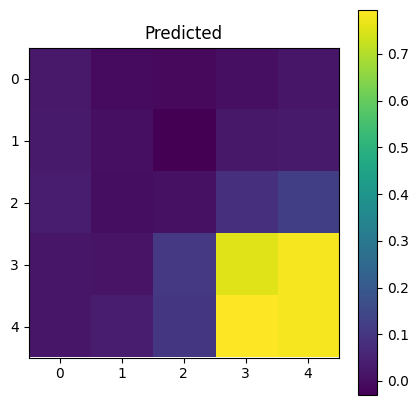

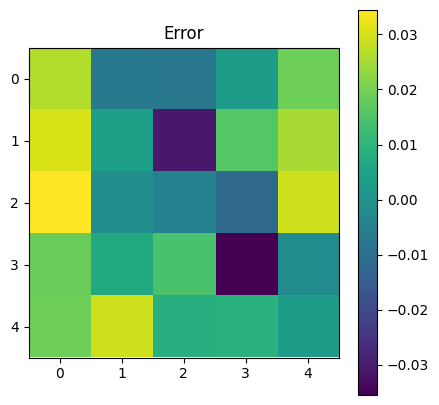

In [6]:
# @title #####__Model Evaluation__

#-------------------------------------------------------------------------------
# TEST NET w/ COMPARISON USED IC

T0_test = np.zeros((nx+2, ny+2))
T0_test[int(0.4 + 0.85 / dx):int(1 / dx + 1), int(0.4 + 0.85 / dy):int(1 / dy + 1)] = 100

x_data_test2, y_data_test2, t_test2 = generate_data(iteration=1, IC=T0_test, total_steps=500, debug_plot=True)

predicted_T = heat_solver.predict([x_data_test2, t_test2], batch_size=1)
print('Predicted Matrix:', predicted_T[0], end='\n')
print('Actual Matrix:', y_data_test2, end='\n')
print('Error Matrix:', predicted_T - y_data_test2, end='\n')


#_______________________________________________________________________________

plt.figure(figsize=(5,5))
plt.imshow(predicted_T[0], cmap='viridis')
plt.colorbar()
plt.title('Predicted')
plt.show()

error = predicted_T - y_data_test2
plt.figure(figsize=(5,5))
plt.imshow(error[0], cmap='viridis')
plt.colorbar()
plt.title('Error')
plt.show()

# 4) _METHODS COMPARISON_

This section compares the solutions of the 2D heat equation using three different numerical methods: Finite Difference (FD), Finite Volume (FV), and Physics Informed Conv-NN (NN).

__Parameters:__  
Domain Size: Lx = Ly = 1.0 units   
Grid Resolution: nx = ny = 5 elements  
Time Steps: nt = 800  
Time Step Size: dt = 0.001 seconds   
Thermal Diffusivity: alpha = 0.01  

__Initial Condition:__   
Temperature initialized from [0, 100] within a specified region.

__Methods:__  
Solutions obtained using FD, FV methods and NN.
Temperature profiles extracted along y-axis at Ly / 2.  

__Visualization:__  
Profiles plotted using Plotly as line plots
Surface plots for initial condition and solutions from each method displayed in 3D.

In [8]:
# @title #####__METHODS COMPARISON__


# Parameters
Lx = Ly = 1.0  # Domain size
nx = ny = 5    # Number of elements in each dimension
dx = Lx / nx   # Element size in x-direction
dy = Ly / ny   # Element size in y-direction
nt = 800      # Number of time steps
dt = 0.001     # Time step size
alpha = 0.01   # Thermal diffusivity

# Initial condition
H = 100.0
M = 60.0
L = 20.0
T0_test = np.zeros((nx+2, ny+2))
#T0_test[int(0.3 + 0.8 / dx):int( 1 / dx + 1), int( 0.3 + 0.8 / dy):int(1 / dy + 1)] = H

T0_test = np.array([[0., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 0., 0., L,  M,  0.],
                    [0., 0., 0., 0., H,  H,  0.],
                    [0., 0., 0., 0., H,  H,  0.],
                    [0., 0., 0., 0., 0., 0., 0.]
                   ])

print('----------------------------------')
print('IC:')
print(T0_test)
print()
print('Sim Time [s]:', np.round(nt*dt, 4))
print('----------------------------------')

x_data_test2, y_data_test2, t_test2 = generate_data(iteration=1, IC=T0_test, total_steps=nt, debug_plot=False)

# Solve the heat equation using differnt methods
T_fd  = solve_heat_equation_FD(T0_test, nt, dt, dx, dy, alpha)
T_fv  = solve_heat_equation_FV(T0_test, nt, dt, dx, dy, alpha)
T_nn  = heat_solver.predict([x_data_test2, t_test2], batch_size=1)[0]*H

profile_fd  = T_fd[:,  int(np.ceil((ny+2)/2))]
profile_fv  = T_fv[:,  int(np.ceil((ny+2)/2))]
profile_nn  = T_nn[:,  int(np.ceil((ny+2)/2))]

x_nodes = np.linspace(0, Lx, nx)
y_nodes = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x_nodes, y_nodes)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=np.linspace(0, Ly, ny), y=profile_fd,  mode='lines', name='FD', line=dict(color='blue',   dash='dash')))
fig1.add_trace(go.Scatter(x=np.linspace(0, Ly, ny), y=profile_fv,  mode='lines', name='FV', line=dict(color='green',  dash='dash')))
fig1.add_trace(go.Scatter(x=np.linspace(0, Ly, ny), y=profile_nn,  mode='lines', name='NN', line=dict(color='orange', dash='dash')))

fig1.update_layout(
    title = 'Temperature Profile along y = L /2')
fig1.show()


fig2 = go.Figure(data=[go.Surface(z=T0_test[1:-1, 1:-1], x=X, y=Y)])
fig2.update_layout(title='2D Heat Equation - IC',
                  scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Temperature'))
fig2.show()

fig3 = go.Figure(data=[go.Surface(z=T_fd, x=X, y=Y)])
fig3.update_layout(title='2D Heat Equation - Finite Difference',
                  scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Temperature'))
fig3.show()

fig4 = go.Figure(data=[go.Surface(z=T_fv, x=X, y=Y)])
fig4.update_layout(title='2D Heat Equation - Finite Volume',
                  scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Temperature'))
fig4.show()

fig5 = go.Figure(data=[go.Surface(z=T_nn, x=X, y=Y)])
fig5.update_layout(title='2D Heat Equation - Conv-NN',
                  scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Temperature'))
fig5.show()


----------------------------------
IC:
[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  20.  60.   0.]
 [  0.   0.   0.   0. 100. 100.   0.]
 [  0.   0.   0.   0. 100. 100.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]

Sim Time [s]: 0.8
----------------------------------
1/1 [==============================] - 0s 29ms/step




---

